# «Модель прогнозирования стоимости жилья для агентства недвижимости»

### ПОСТАНОВКА ЗАДАЧИ

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Типовая задача из области Data Science, основанная на данных о недвижимости в США.

**Бизнес-задача:** улучшить финансовые показатели компании за счет уменьшения времени на обработку информации о недвижимости у риелторов.

**Техническая задача для вас как для специалиста в Data Science:** разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

**Основные цели проекта:**
1. Провести разведывательный анализ и очистку исходных данных.
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

Итак, была произведена обработка и очистка данных. Далее этап EDA.

In [260]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import category_encoders as ce

In [239]:
#прочитаем данные из файла
r = pd.read_csv('clean_data.csv', sep = ',') 

In [240]:
#проверим, что данные выгрузились корректно, для этого выведем первые две строки датафрейма
display('Очищенная таблица данных недвижимости',r.head())

'Очищенная таблица данных недвижимости'

,status,baths,city,sqft,beds,state,target,heating,cooling,sch_rating,sch_dist,type,last_year
0,active,3.5,southern pines,2900.0,4.0,NC,418000.0,1,0,5.0,5.5,single_1,2019
1,active,3.0,spokane valley,1947.0,3.0,WA,310000.0,0,0,4.0,1.5,single_2,2019
2,active,2.0,los angeles,3000.0,3.0,CA,2895000.0,1,1,6.0,1.6,single_1,1967
3,active,8.0,dallas,6457.0,5.0,TX,2395000.0,1,1,9.0,0.7,single_3,2006
4,active,3.0,philadelphia,680.0,2.0,PA,209000.0,1,1,2.0,0.2,townhouse,1920


### Создадим признак climate_system

Он будет отражать наличие или отсутствие системы, поддерживающей необходимую температуру, т.е. его значения будут находиться на пересечении значений признаков heating и cooling равных 1 (т.е. заполненных данных)

In [241]:
def climate_system(x,y):
    '''Функция принимает два аргумента.
    
       Функция возвращает 1, если оба аргумента равны единицы, возвращает 0, если оба аргумента равны 0.
    '''
    if (x==1) and (y==1):#если x равно 1 и y равно 1
        return 1 #возвращаем 1
    else:#иначе
        return 0 #возвращаем 0

In [242]:
# применим нашу формулу для построения признака к столбцам cooling и heating
r['climate_system']=r[['heating','cooling']].apply(lambda x: climate_system(*x), axis=1)
# удалим столбцы из таблицы
r.drop(['heating','cooling'], axis=1, inplace=True)

### Создадим признак property_age

Он будет отражать возраст недвижимости, получим его вычетом признака last_year из 2023 года.

In [243]:
#создадим признак property_age
r['property_age']=r['last_year'].map(lambda x: int(2023 - x))
#удалим признак last_year
r.drop('last_year', axis=1, inplace=True)

### Создадим признак capital_state

Он будет отражать является ли город столицей штата или нет: 1 - столица штата, 0 - не столица.

In [244]:
#создадим словарь штатов и столиц
state_capital = {'AL':'Montgomery','AK':'Juneau','AZ':'Phoenix','AR':'rock little','CA':'sacramento',
                 'CO':'denver','CT':'hartford','DE':'dover','FL':'Tallahassee','GA':'Atlanta',
                 'ID':'Boise','IL':'Springfield','IN':'Indianapolis','IA':'Des Moines','KS':'Topeka',
                 'KY':'Frankfort','LA':'Baton Rouge','ME':'Augusta','MD':'Annapolis','MA':'Boston',
                 'MI':'Lansing','MN':'Saint Paul','MS':'Jackson','MO':'Jefferson','MT':'Helena',
                 'NE':'Lincoln','NV':'Carson','NH':'Concord','NJ':'Trenton', 'NM':'Santa Fe','NY':'Albany',
                 'NC':'Raleigh','ND':'Bismarck','OH':'Columbus','OK':'Oklahoma','OR':'Salem', 
                 'PA':'Harrisburg', 'RI':'Providence','SC':'Columbia','SD':'Pierre','TN':'Nashville',
                 'TX':'Austin','UT':'Salt Lake', 'VT':'Montpelier','VA':'Richmond','WA':'Olympia',
                 'WV':'Charleston','WI':'Madison','WY':'Cheyenne','HI':'Honolulu','DC':'Washington'}

In [245]:
#напишем функцию, которая поможет создать признак capital_state
def get_capital(c,s):
    '''Функция на вход получает два значения, которые представляют собой строки.
       
       Функция возвращает 1, если город соответствует столице штата, 0, если не соответствует
    '''
    #если значение с равно значению из словаря, соответствующему ключу словаря s
    if (state_capital.get(s).lower())==c:
        result= 1 #то присваиваем result значение 1
    else: #иначе, если значение отлично от значения из словаря
        result= 0 #то присваиваем result значение 0
    return result #возвращаем result

In [246]:
#создадим с помощью функции get_capital признак capital_state
r['capital_state']=r[['city','state']].apply(lambda x: get_capital(*x), axis=1)

In [247]:
#проверим информативность признака
r['capital_state'].value_counts()/r.shape[0]*100

capital_state
0    90.985941
1     9.014059
Name: count, dtype: float64

Поскольку ни одно из уникальных значений признака не превышает 95 % , можно считать признак информативным.

In [248]:
#признак city можем удалить
r.drop('city', axis=1, inplace=True)

Посмотрим, какие признаки у нас остались.

In [249]:
r.head()

,status,baths,sqft,beds,state,target,sch_rating,sch_dist,type,climate_system,property_age,capital_state
0,active,3.5,2900.0,4.0,NC,418000.0,5.0,5.5,single_1,0,4,0
1,active,3.0,1947.0,3.0,WA,310000.0,4.0,1.5,single_2,0,4,0
2,active,2.0,3000.0,3.0,CA,2895000.0,6.0,1.6,single_1,1,56,0
3,active,8.0,6457.0,5.0,TX,2395000.0,9.0,0.7,single_3,1,17,0
4,active,3.0,680.0,2.0,PA,209000.0,2.0,0.2,townhouse,1,103,0


In [250]:
#категориальные признаки status, type, state
cat_feature = ['status','type','state']
#бинарные признаки
bin_feature = ['climate_system','capital_state']
#числовые признаки
num_feature = ['baths','sqft','beds','sch_rating','sch_dist','property_age']

Рассмотрим взаимосвязи перечисленных признаков с целевым признаком target. 

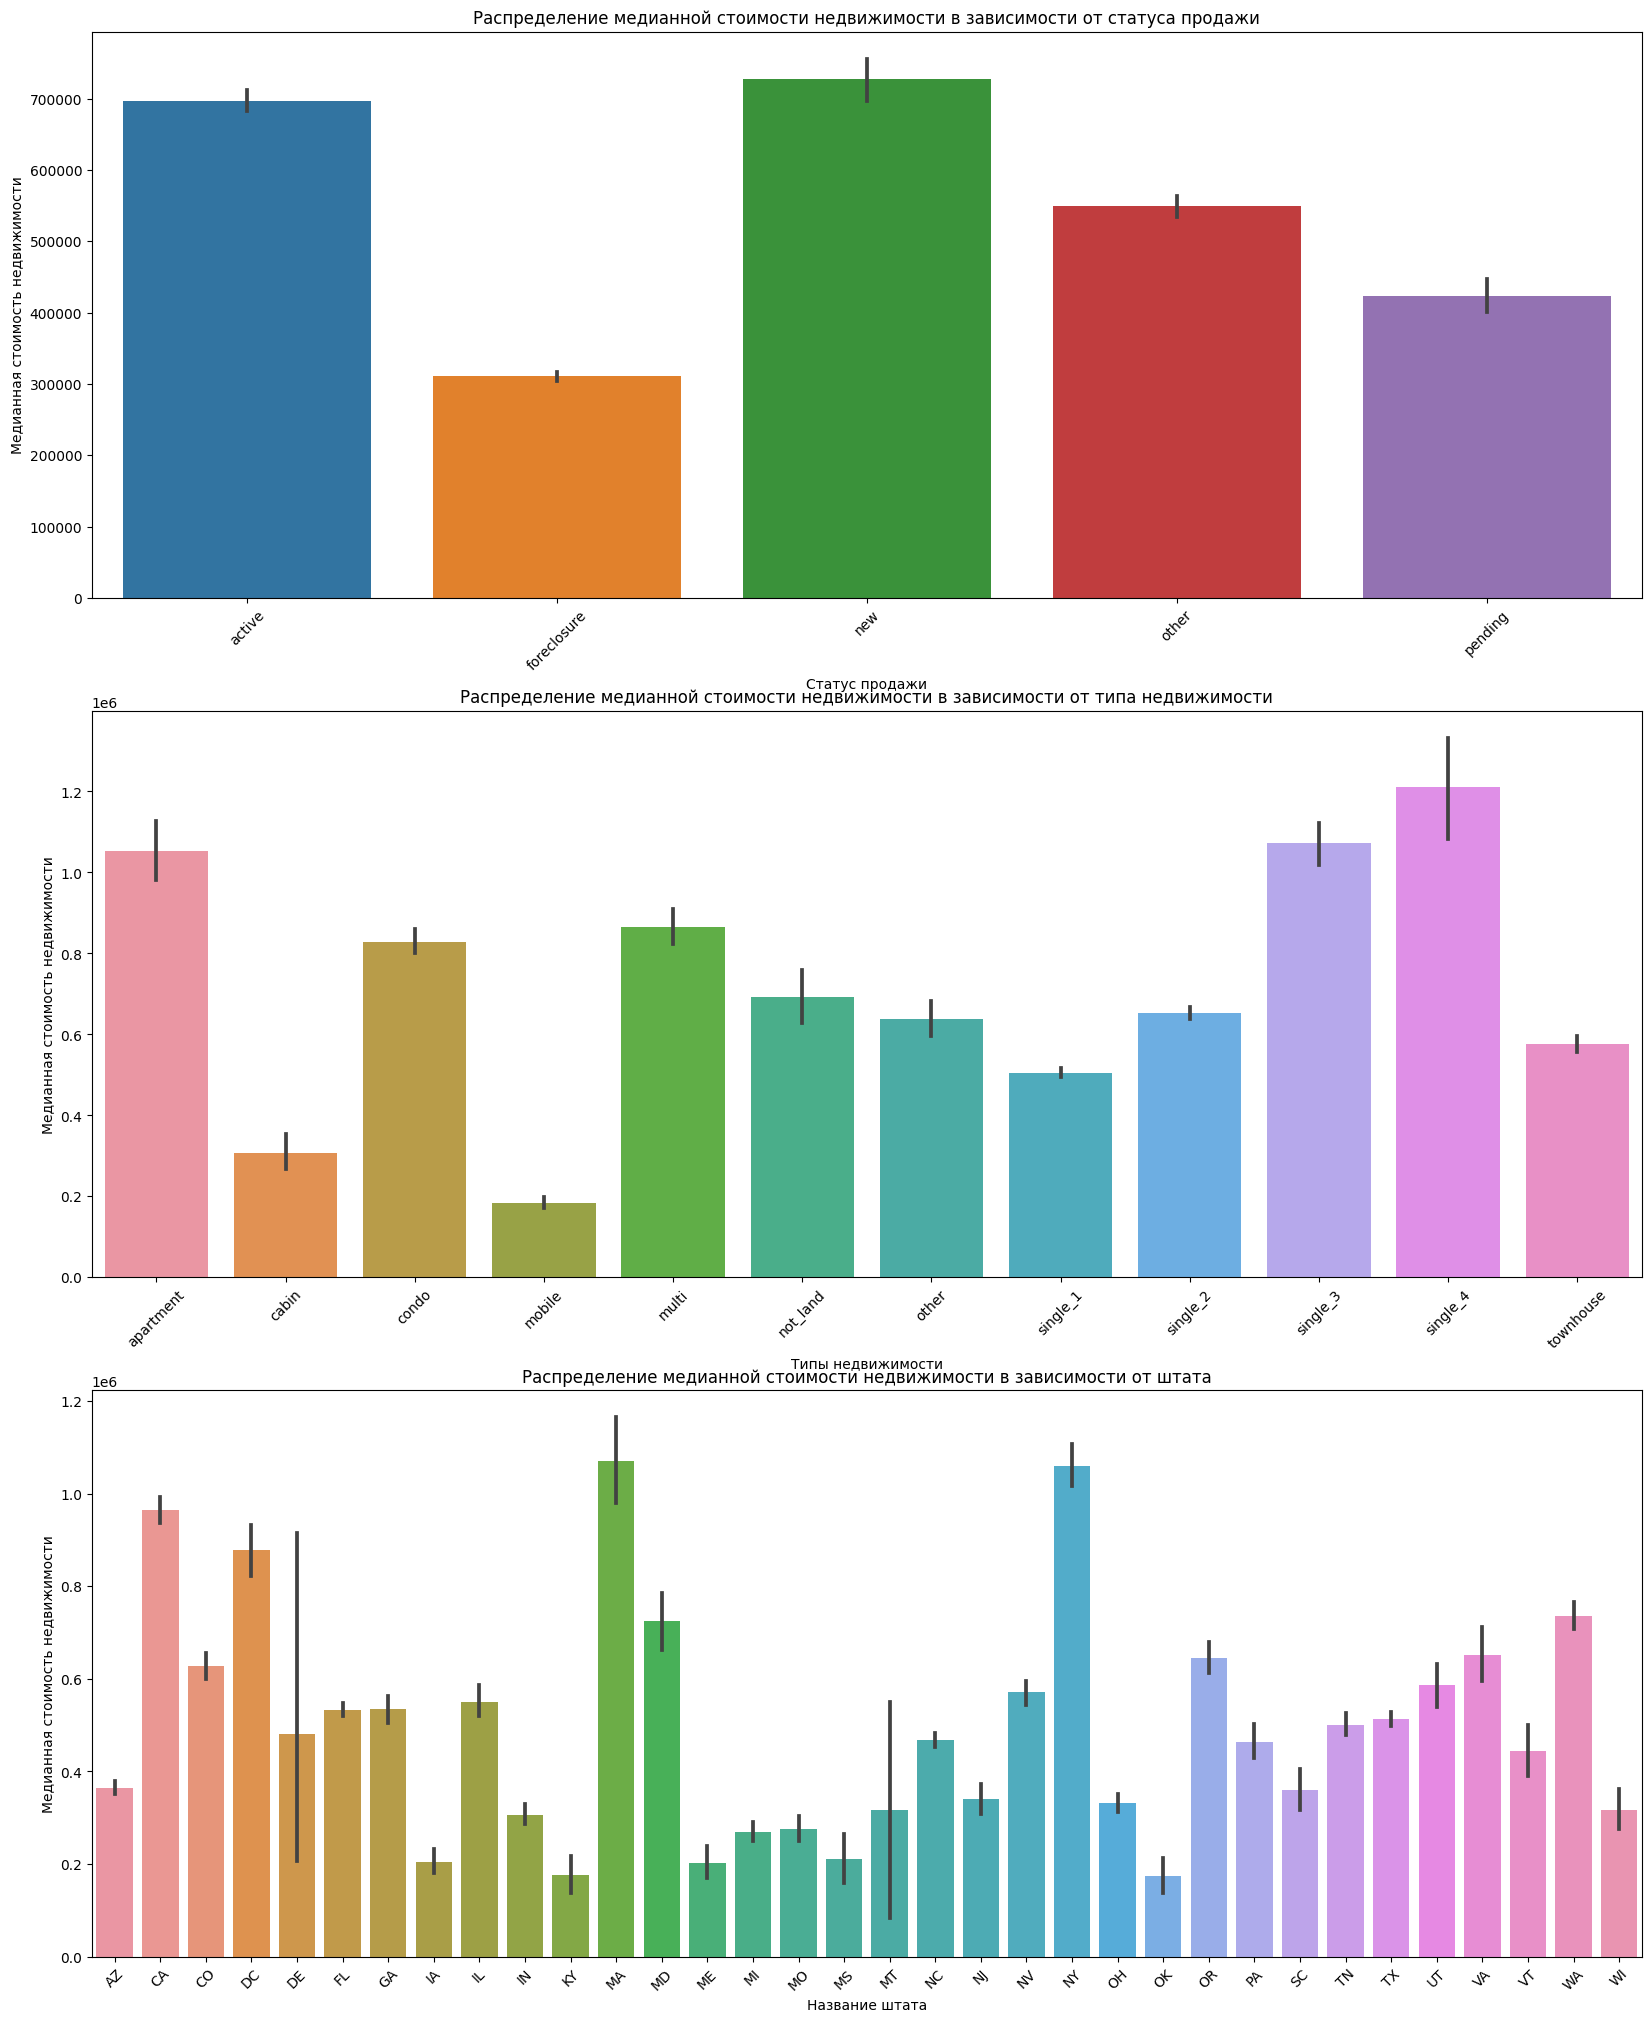

In [251]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 25))

#оформим вспомогательную таблицу для построения зависимости между медианной стоимостью и статусом продажи
target_status = r.groupby(['status','target'], as_index=False)['target'].median()
#построим столбчатую диаграмму
barplot = sns.barplot(
    data = target_status,
    x = 'status',
    y = 'target',
    ax=axes[0]
);
barplot.set_title('Распределение медианной стоимости недвижимости в зависимости от статуса продажи');
barplot.set_xlabel('Статус продажи');
barplot.set_ylabel('Медианная стоимость недвижимости');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

#оформим вспомогательную таблицу для построения зависимости между медианной стоимостью и статусом продажи
target_type = r.groupby(['type','target'], as_index=False)['target'].median()
#построим столбчатую диаграмму
barplot = sns.barplot(
    data = target_type,
    x = 'type',
    y = 'target',
    ax=axes[1]
);
barplot.set_title('Распределение медианной стоимости недвижимости в зависимости от типа недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Медианная стоимость недвижимости');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

#оформим вспомогательную таблицу для построения зависимости между медианной стоимостью и статусом продажи
target_state = r.groupby(['state','target'], as_index=False)['target'].median()
#построим столбчатую диаграмму
barplot = sns.barplot(
    data = target_state,
    x = 'state',
    y = 'target',
    ax=axes[2]
);
barplot.set_title('Распределение медианной стоимости недвижимости в зависимости от штата');
barplot.set_xlabel('Название штата');
barplot.set_ylabel('Медианная стоимость недвижимости');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);


На мой взгляд, все из категориальных признаков влияют на целевой признак target.

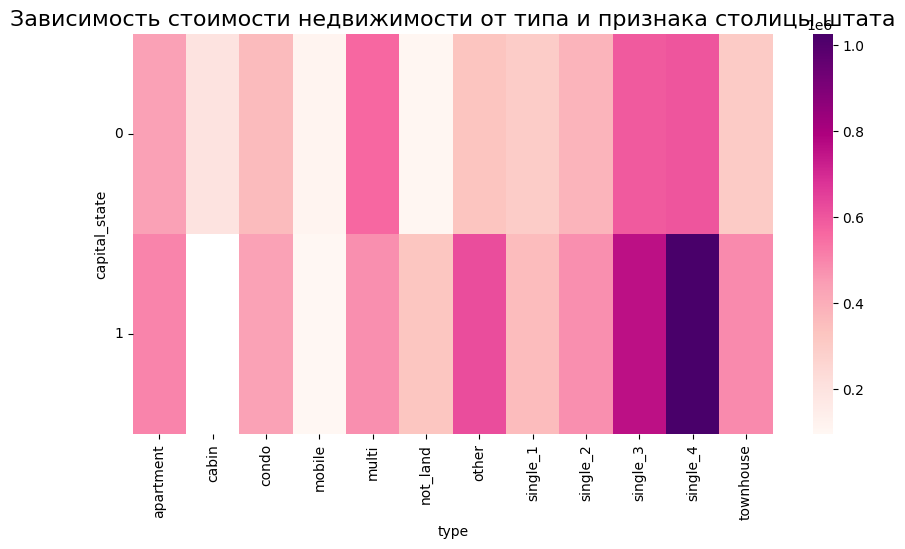

In [252]:
#сформируем вспомогательную таблицу
pivot_cap_type = r.pivot_table(
    values='target',
    index = 'capital_state',
    columns = 'type',
    aggfunc = 'median'
)
#отрисуем график
fig = plt.figure(figsize=(8,4))
axes = fig.add_axes([0,0,1,1])
fig_pivot = sns.heatmap(
    data = pivot_cap_type,
    cmap='RdPu'
)
axes.set_title('Зависимость стоимости недвижимости от типа и признака столицы штата', fontsize = 16)
axes.yaxis.set_tick_params(rotation = 360)

Итак, что мы видим, особенно сильное влияние на стоимость недвижимости оказывает сочетание типа недвижимости single_1 и принадлежности города , в котором находится недвижимость, к столице штата.

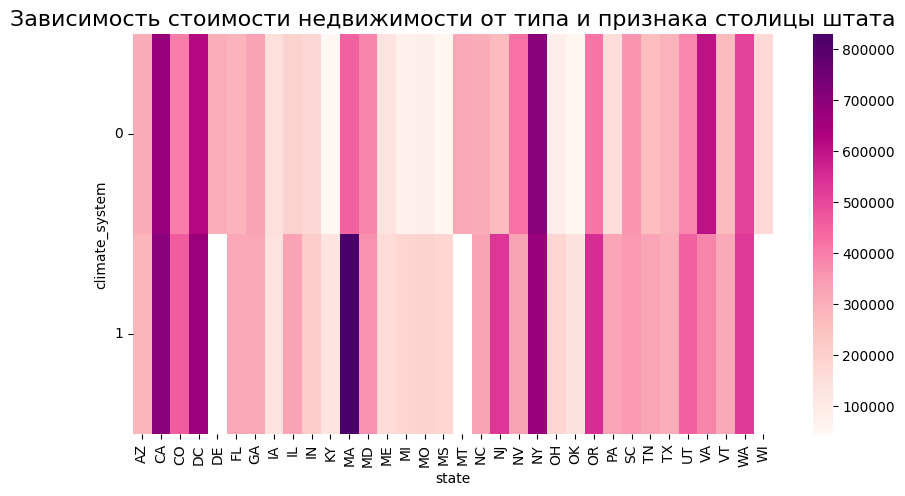

In [253]:
#сформируем вспомогательную таблицу
pivot_clim_state = r.pivot_table(
    values='target',
    index = 'climate_system',
    columns = 'state',
    aggfunc = 'median'
)
#отрисуем график
fig = plt.figure(figsize=(8,4))
axes = fig.add_axes([0,0,1,1])
fig_pivot = sns.heatmap(
    data = pivot_clim_state,
    cmap='RdPu'
)
axes.set_title('Зависимость стоимости недвижимости от типа и признака столицы штата', fontsize = 16)
axes.yaxis.set_tick_params(rotation = 360)

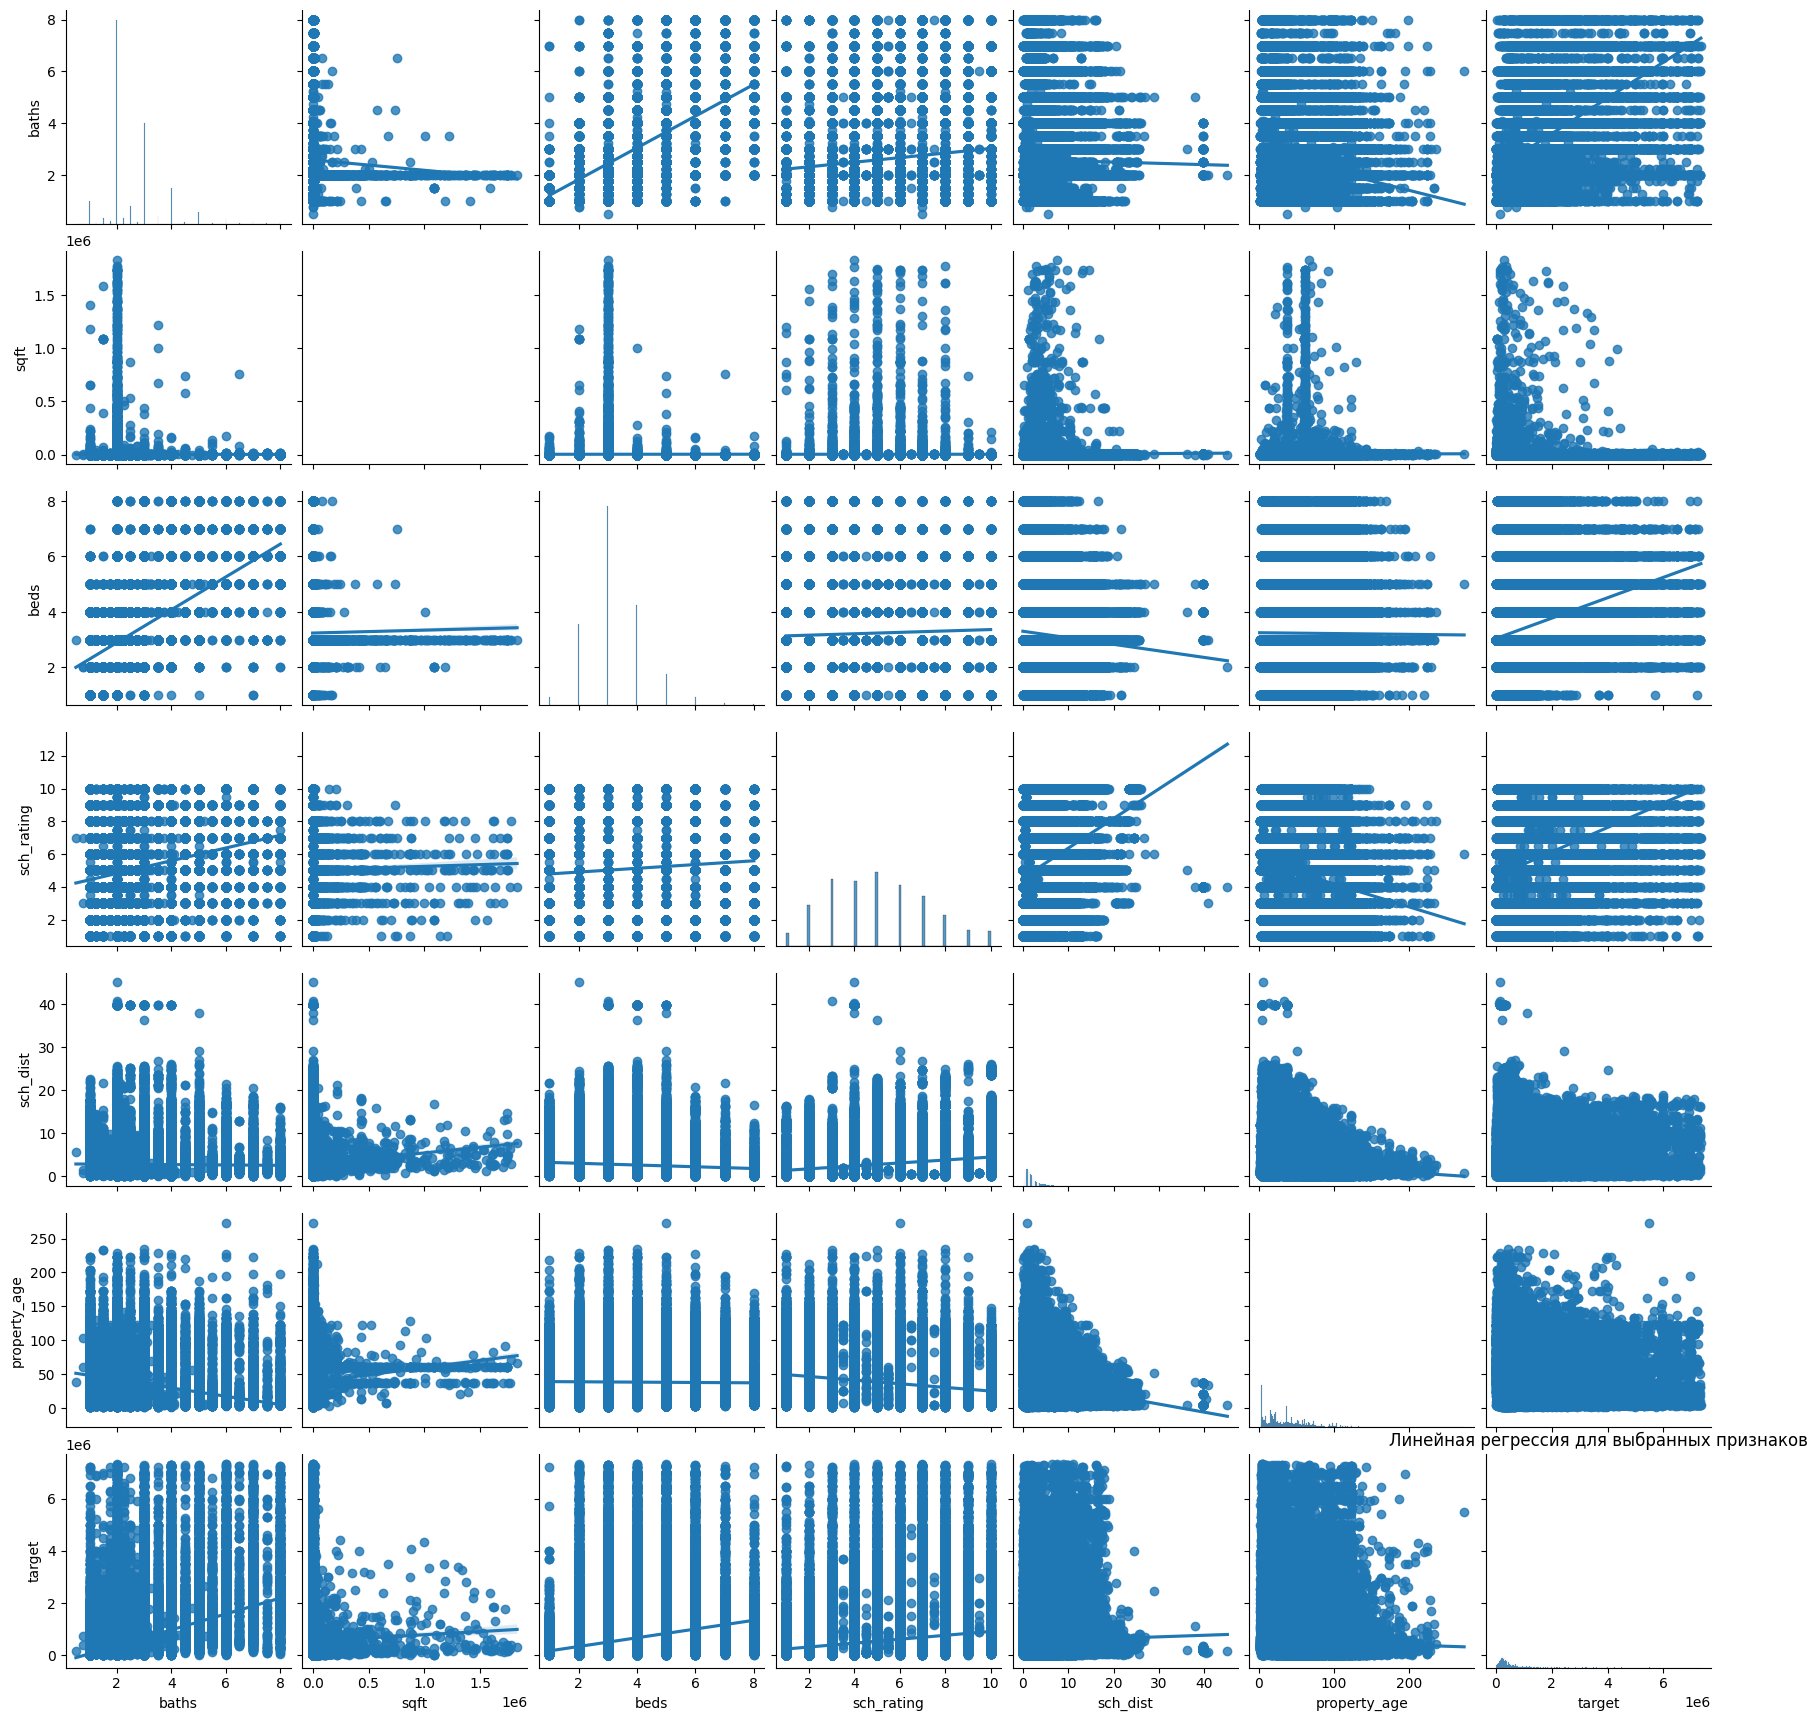

In [255]:
# отбираем только нужные признаки из датасета
#feature_for_fig = r[['baths','sqft','beds','sch_rating','sch_dist','property_age','target']]
# строим линейную регрессию для выбранных признаков
#sns.pairplot(feature_for_fig, kind='reg')
# добавляем заголовок
#plt.title('Линейная регрессия для выбранных признаков')
# отображаем график
#plt.show()

In [1]:
for feature in num_feature:
    histplot = sns.histplot(data=r, x=feature, bins=500 );
    histplot.set(ylim=(0,160000)); 
    histplot.set(xlim=(0,30));
    histplot.set_title('Гистограмма распределения признака {0}'.format(feature));
    histplot.set_xlabel('Число {0}'.format(feature));
    plt.show()

NameError: name 'num_feature' is not defined

Text(0.5, 1.0, 'Зависимость прибыльности скважины от пористости')

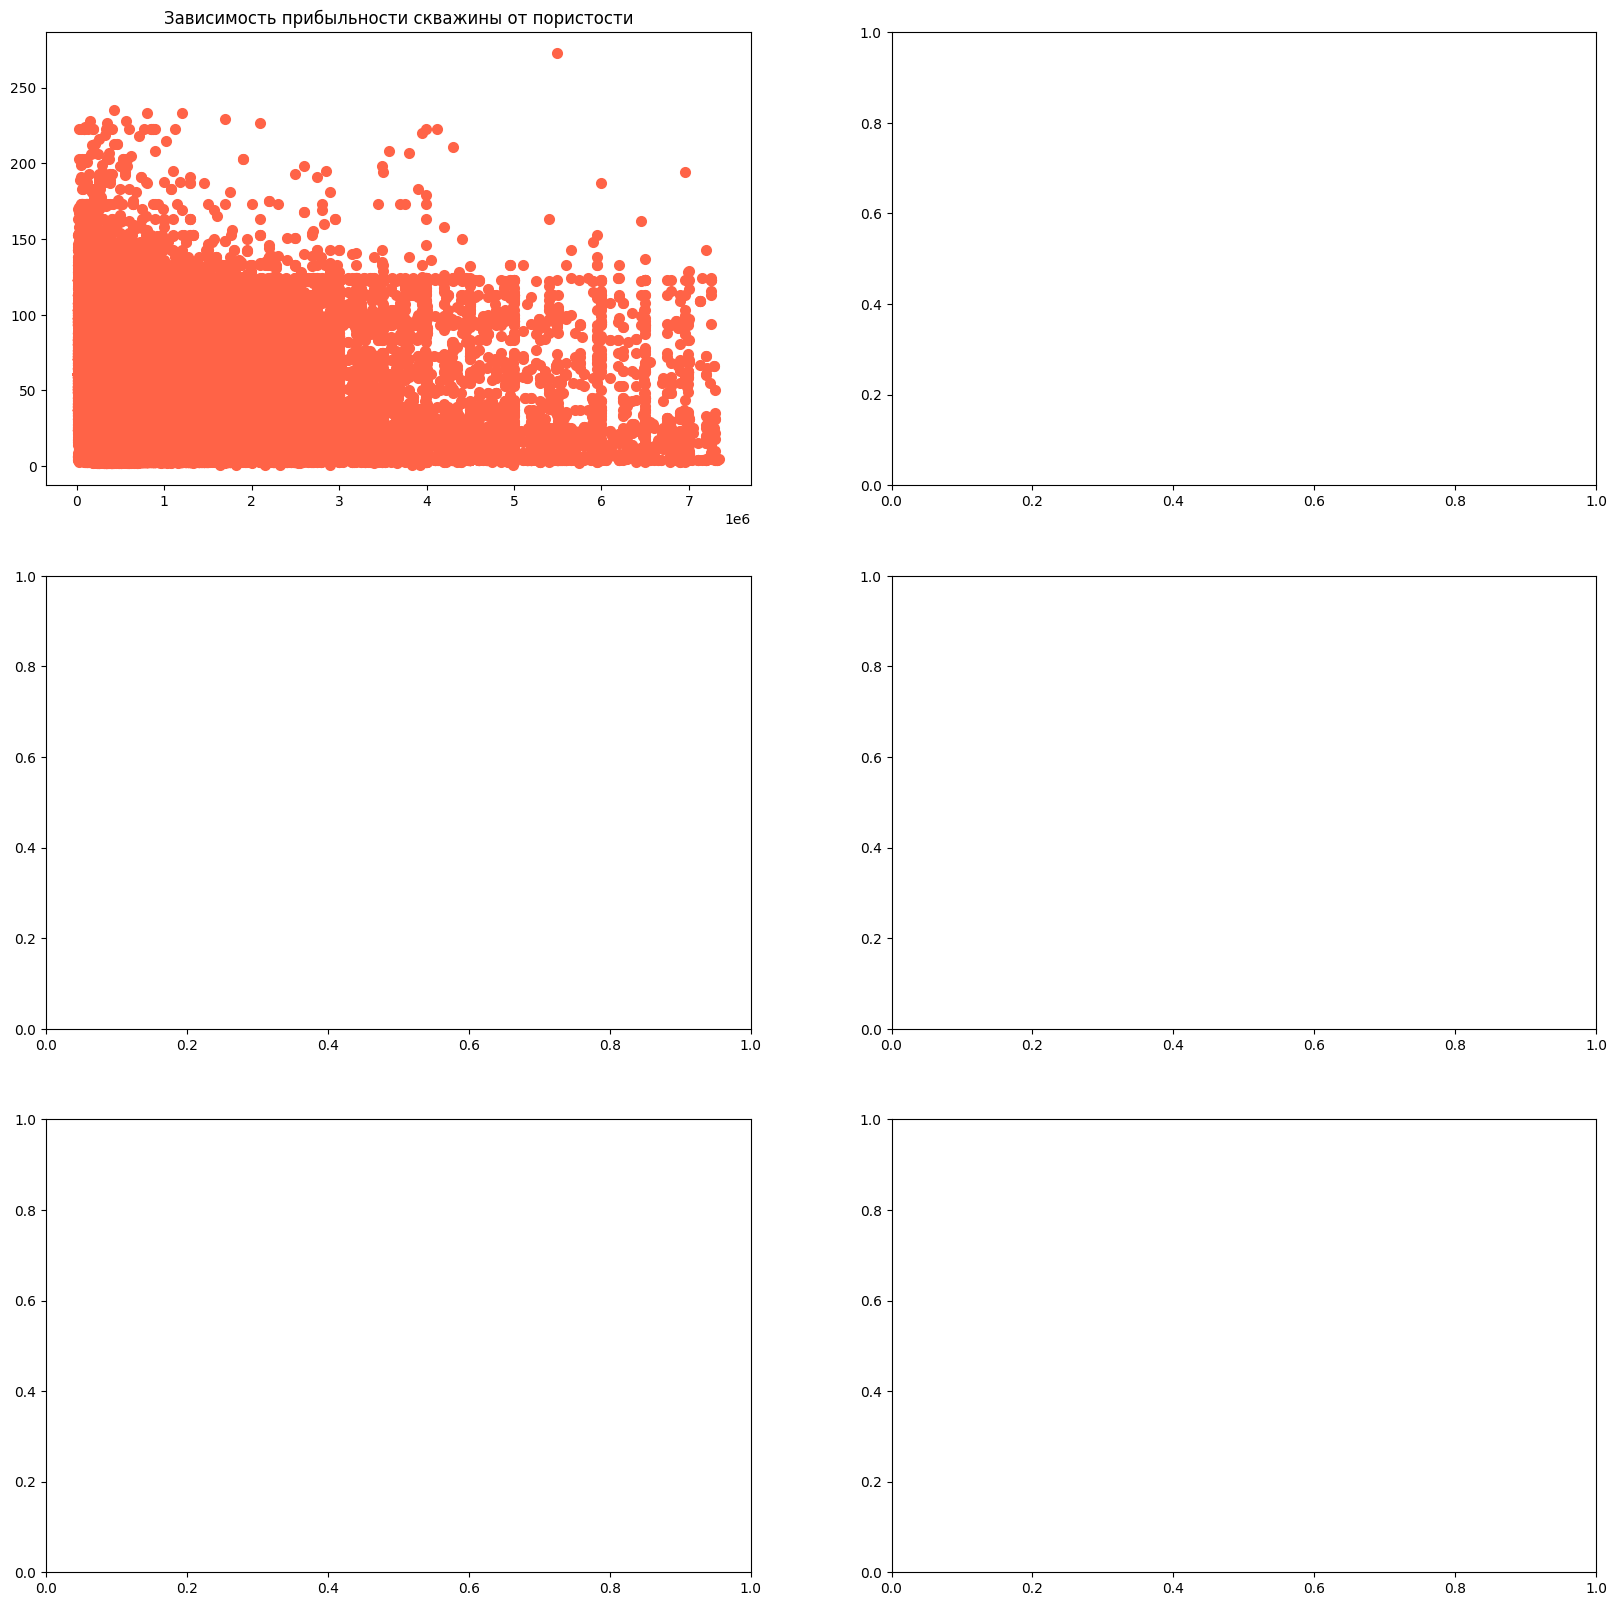

In [311]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

axes[0][0].scatter(
    r['target'],
    r['property_age'],
    label="Пористость скважины",
    color="tomato",
    lw=2,
)
axes[0][0].set_title('Зависимость прибыльности скважины от пористости')

In [307]:
feat_table = r[num_feature].copy()
feat_table[num_feature] = feat_table[num_feature].applymap(lambda x: np.log(x+1))

In [308]:
feat_table

,baths,sqft,beds,sch_rating,sch_dist,property_age
0,1.504077,7.972811,1.609438,1.791759,1.871802,1.609438
1,1.386294,7.574558,1.386294,1.609438,0.916291,1.609438
2,1.098612,8.006701,1.386294,1.945910,0.955511,4.043051
3,2.197225,8.773075,1.791759,2.302585,0.530628,2.890372
4,1.386294,6.523562,1.098612,1.098612,0.182322,4.644391
...,...,...,...,...,...,...
321992,1.386294,7.257003,1.098612,1.386294,0.182322,2.639057
321993,1.945910,8.298540,1.791759,2.397895,2.867899,3.526361
321994,1.386294,7.601402,1.386294,1.386294,1.945910,4.605170
321995,1.386294,7.050123,1.386294,1.791759,0.405465,4.304065


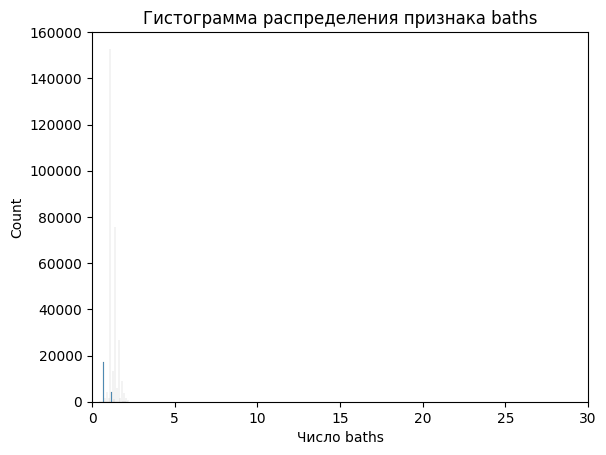

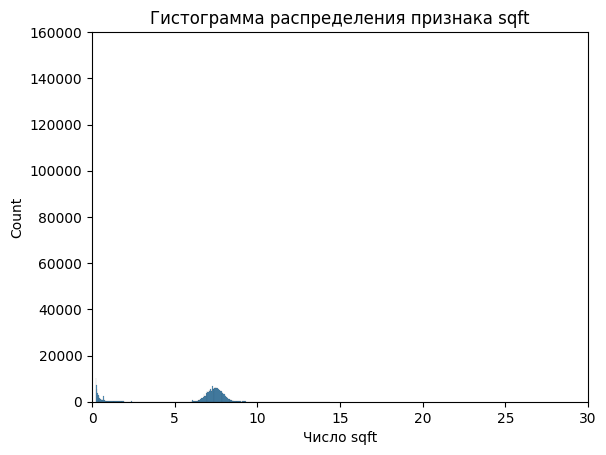

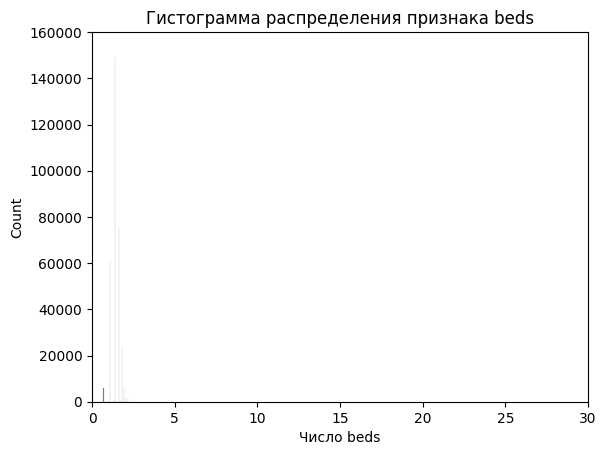

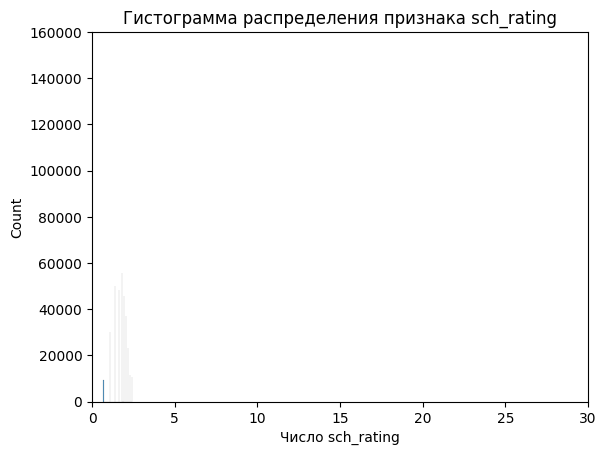

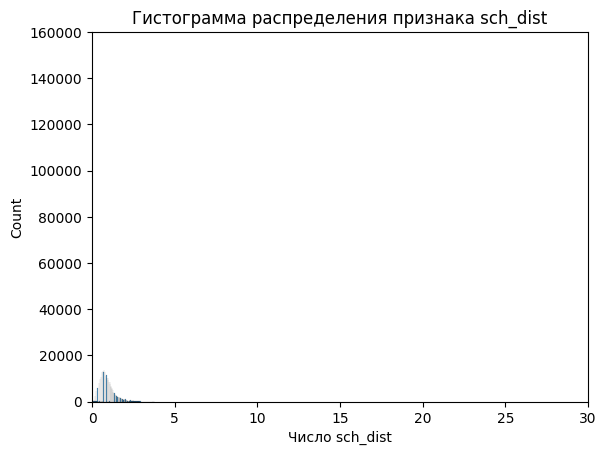

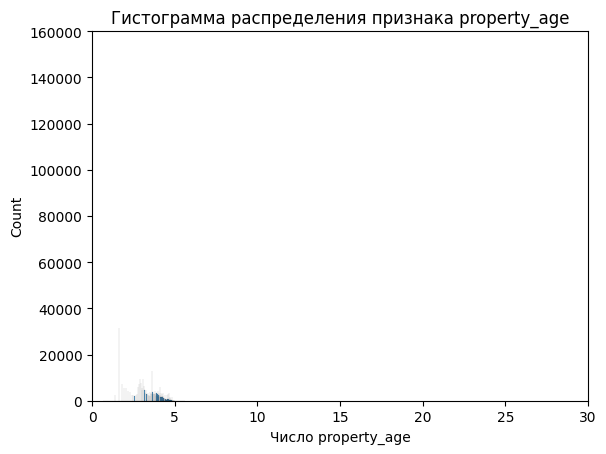

In [309]:
for feature in num_feature:
    histplot = sns.histplot(data=feat_table, x=feature, bins=500 );
    histplot.set(ylim=(0,160000)); 
    histplot.set(xlim=(0,30));
    histplot.set_title('Гистограмма распределения признака {0}'.format(feature));
    histplot.set_xlabel('Число {0}'.format(feature));
    plt.show()

Для выявления мультиколлинеарности в признаках построим матрицу корреляций, но прежде закодируем признаки.

In [257]:
#отобразим количество уникальных значений для выбора метода кодировки
display('Количество уникальных значений в категориальных признаках:',
        r.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

status     5
state     34
type      12
dtype: int64

In [258]:
r1=r.copy()

Для признаков status и type выберем однократное кодирование, так как они являются номинальными и число их уникальных значений меньше 15.

Для признака state выберем бинарный тип кодирования, посколько число уникальных значений превышает 15 и он также является номинальным признаком.

In [262]:
#закодируем категориальные признаки
# Создаем список признаков для одиночного кодирования
one_feature = ['status', 'type']
# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=one_feature, use_cat_names=True)
encoded_data = encoder.fit_transform(r1[one_feature])
# Присоединяем к датафрейму закодированные признаки
r1 = pd.concat([r1, encoded_data], axis=1)

# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(r1[['state']])
# Присоединяем к датафрейму закодированные признаки
r1 = pd.concat([r1, encoded_data], axis=1)

# Удалим исходные признаки и выведем размер датафрейма
r1 = r1.drop(['status', 'type','state'], axis=1)
print('Размер итоговой таблицы: {0}'.format(r1.shape))

Размер итоговой таблицы: (321997, 55)


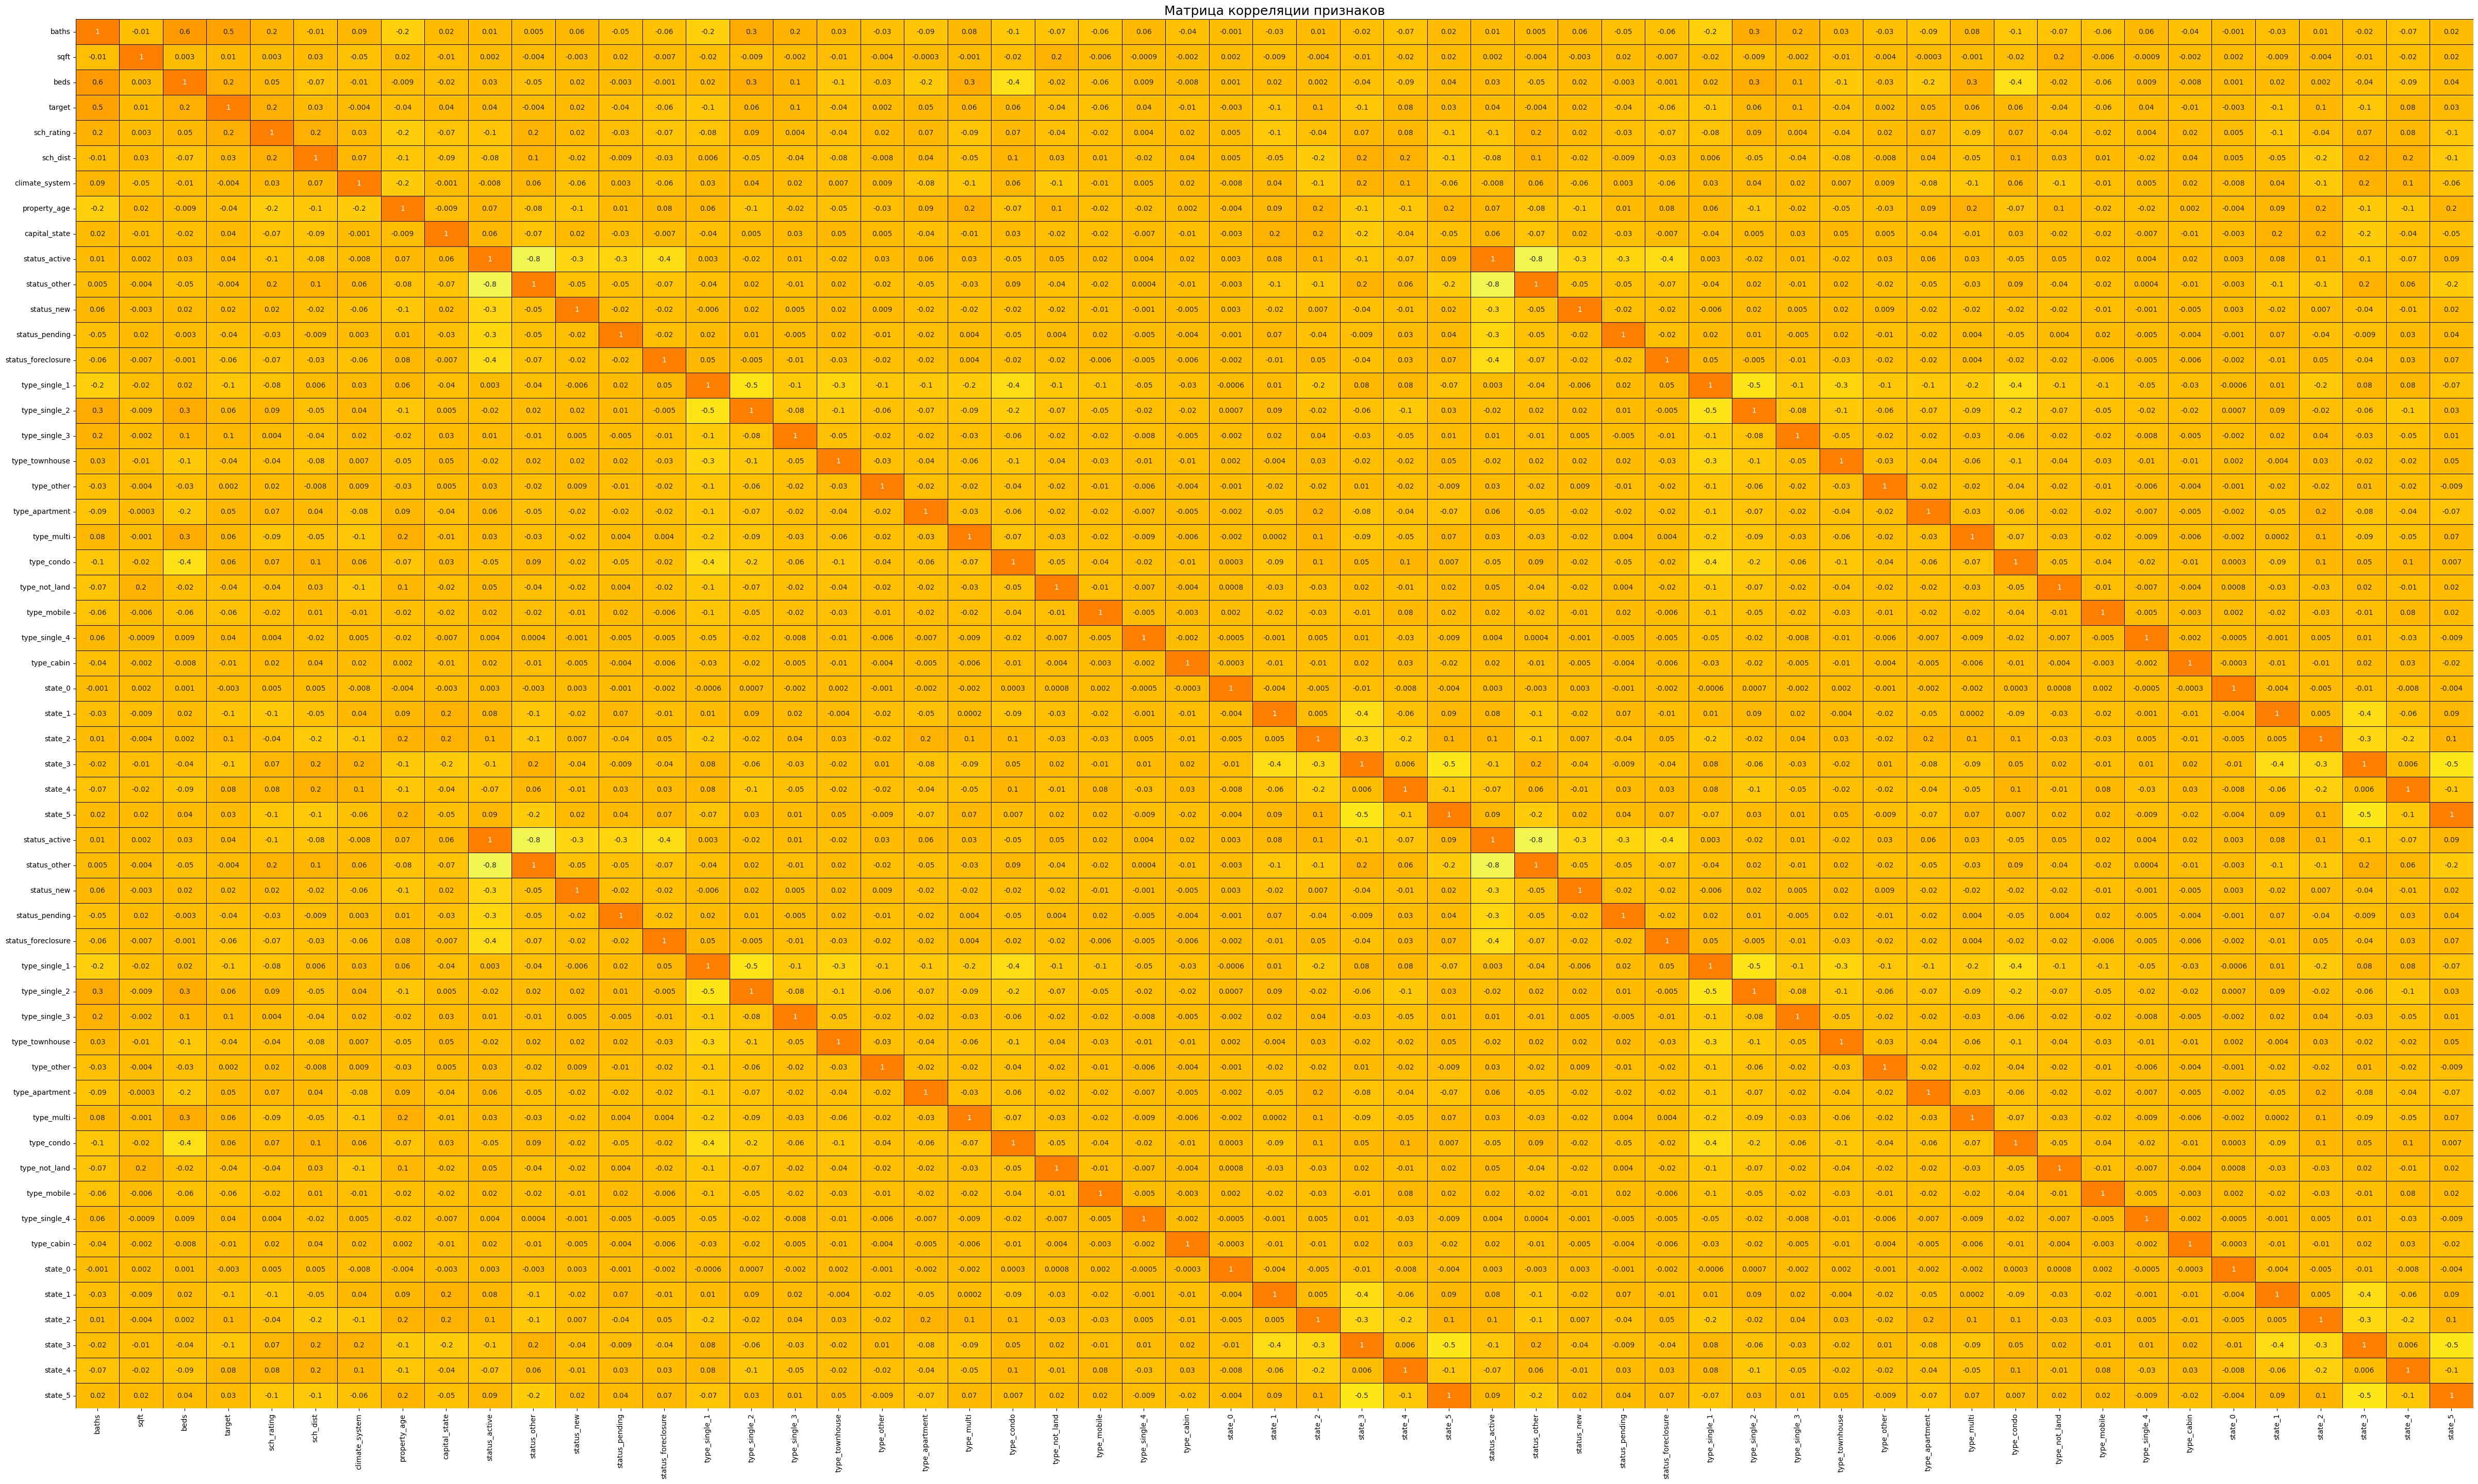

In [287]:
# построим матрицу корреляции
fig = plt.figure(figsize=(60, 35))
heatmap = sns.heatmap(
    data = r1.corr(),
    annot = True,
    fmt = '.1g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'Wistia',
    linewidths=0.5, 
    linecolor='black',
    cbar=False
);
heatmap.set_title('Матрица корреляции признаков', fontsize=18);

К сожалению лучше вывести матрицу корреляции не получилось из-за большого числа рассматриваемых признаков. Отмечу следующее: между целевым признаком и признаками 

In [ ]:
#построим разпределение признака baths, чтобы определить есть ли выбросы
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

boxplot = sns.boxplot(data = r5,x = 'baths',ax=axes[0]);
boxplot.set(xlim=(0,50)); 
boxplot.set_title('Коробчатая диаграмма числа ванных комнат');
boxplot.set_xlabel('Число ванных комнат');

histplot = sns.histplot(data=r5, x='baths', bins=500, ax=axes[1]);
histplot.set(ylim=(0,160000)); 
histplot.set(xlim=(0,60));
histplot.set_title('Гистограмма распределения числа ванных комнат');
histplot.set_xlabel('Число ванных комнат');

In [ ]:
#заменим 0 значения на значения nan, чтобы посмотреть есть ли в таблице неинформативные наблюдения
num_feature = ['baths','sqft','beds','sch_rating','sch_dist','last_year']
r18[num_feature]=r18[num_feature].replace(0,np.nan)

In [ ]:
# отрисуем диаграммы для target до обработки от выбросов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('target', fontsize=14)

# Ящик с усами
ax1.boxplot(r3['sqft'])
ax1.set_title('Boxplot: target')
ax1.set_ylabel('target')
    
# Гистограмма
ax2.hist(r3['sqft'], bins=10 );
ax2.set_title(f'Histplot: target')
ax2.set_ylabel('target')

In [ ]:
#попробуем логарифмировать данные
feature_log = r7[num_feature].applymap(lambda x: np.log(x + 1))

In [ ]:
#построим распределение логарифмированных признаков
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

histplot = sns.histplot(data=r7, x = 'baths', bins=100, ax=axes[0][0]);
histplot.set_title('Гистограмма распределения log_baths');
histplot.set_xlabel('log_baths');

histplot = sns.histplot(data=r7, x = 'beds', bins=100, ax=axes[0][1]);
histplot.set_title('Гистограмма распределения log_beds');
histplot.set_xlabel('log_beds');

histplot = sns.histplot(data=r7, x = 'sqft', bins=100, ax=axes[1][0]);
histplot.set_title('Гистограмма распределения log_sqft');
histplot.set_xlabel('log_sqft');

histplot = sns.histplot(data=r7, x = 'sch_rating', bins=100, ax=axes[1][1]);
histplot.set_title('Гистограмма распределения log_sch_rating');
histplot.set_xlabel('log_sch_rating');

histplot = sns.histplot(data=r7, x = 'sch_dist', bins=100, ax=axes[2][0]);
histplot.set_title('Гистограмма распределения log_sch_dist');
histplot.set_xlabel('log_sch_dist');

histplot = sns.histplot(data=r7, x = 'property_age', bins=100, ax=axes[2][1]);
histplot.set_title('Гистограмма распределения log_property_age');
histplot.set_xlabel('log_property_age');

Для анализа взаимосвязи категориальных признаков и целевого признака будем использовать бисериальный коэффициент корреляции. Прежде закодируем категориальные признаки.

In [ ]:
#найдем бисериальный коэффициент корреляции
# пройдемся циклом по списку названий столбцов таблицы с закодированными данными
for col in ecoder_lst:
    print(f'{col}:',pointbiserialr(encoded_data[col], r7['target']))